<a href="https://colab.research.google.com/github/cristobalperez70-max/Aprendizaje-Maquina/blob/main/Transformer_Encoder_MiniExp2_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mini-Experimento 2 — Degradación por *shuffle* con / sin Positional Encoding (PE)

**Autor:**: Cristóbal Pérez González.

**Fecha:** 2025-11-13

Este Colab implementa un encoder Transformer (basado en los 4 bloques del taller) y ejecuta el Mini-Experimento 2: **Degradación por shuffle con / sin PE**.

El notebook está organizado en celdas con explicación y código separados. Se simulan 3 meses de datos climáticos (cada 10 minutos) para 3 variables: Temperatura (°C), Humedad (fracción) y Precipitación (mm).

**Resumen del experimento**:
- Se construyen dos modelos Transformer idénticos salvo por la inclusión de Positional Encoding en uno.
- Se entrenan ambos para predecir el siguiente instante (t+1) a partir de una ventana temporal de longitud L.
- Se evalua el MSE en secuencias ordenadas y en secuencias **barajadas internamente** (shuffle por ventana).
- Finalmente se visualiza la degradación en MSE cuando se baraja la secuencia, comparando ambos modelos.




## 1) Imports y configuración inicial
En esta celda se importan las librerías necesarias y se fijan semillas para reproducibilidad. También se definen parámetros experimentales que luego podrá modificar.

In [2]:
# Imports y configuración
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import math
import random
import os

# Reproducibilidad
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
random.seed(SEED)

# Parámetros experimentales (ajustables)
SAMPLE_INTERVAL_MIN = 10           # cada 10 minutos
DAYS = 90                          # ≈ 3 meses
TOTAL_POINTS = DAYS * 24 * (60 // SAMPLE_INTERVAL_MIN)
WINDOW_LEN = 24                    # L = 24 pasos (4 horas)
PRED_HORIZON = 1                   # predecir el siguiente paso (t+1)
TRAIN_RATIO = 0.7
BATCH_SIZE = 64
D_MODEL = 64
NUM_LAYERS = 2
NUM_HEADS = 4
FFN_DIM = 128
EPOCHS = 6
LR = 1e-3
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('Total de muestras (3 meses cada 10 min):', TOTAL_POINTS)

Total de muestras (3 meses cada 10 min): 12960


## 2) Simulación de datos climáticos (3 meses, cada 10 minutos)
Se generan señales realistas sencillas con componentes diurnas y ruido:
- Temperatura: seno diario + tendencia + ruido.
- Humedad: correlacionada inversamente con temperatura + ruido.
- Precipitación: procesos esporádicos (pulsos) con probabilidad baja.

data shape: (12960, 3)


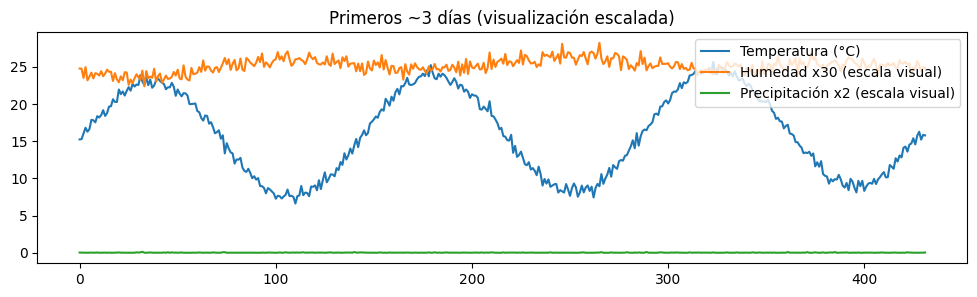

In [3]:
# Simulación
T = TOTAL_POINTS
t = np.arange(T)

# Componente diaria (periodo = 24h -> 24*(60/interval) pasos)
period_daily = 24 * (60 // SAMPLE_INTERVAL_MIN)

# Temperatura: mezcla de senos y ligera tendencia
temp = 15 + 8 * np.sin(2 * np.pi * t / period_daily) + 0.005 * t + np.random.normal(0, 0.5, size=T)

# Humedad: inversa suave a temperatura + ruido, mantenida en [0.2, 0.99]
hum = 0.85 - 0.003 * temp + 0.05 * np.sin(2 * np.pi * t / (period_daily*7)) + np.random.normal(0, 0.02, size=T)
hum = np.clip(hum, 0.2, 0.99)

# Precipitación: eventos raros (pulsos) simulados con Poisson thinning
prec = np.zeros(T)
rng = np.random.default_rng(SEED)
event_prob = 0.0015  # baja probabilidad por paso
event_indices = rng.uniform(size=T) < event_prob
prec[event_indices] = rng.gamma(2.0, 1.5, size=event_indices.sum())  # mm
# añadir ruido pequeóo
prec += np.random.exponential(0.01, size=T)

data = np.stack([temp, hum, prec], axis=1)  # (T, 3)
print('data shape:', data.shape)

# breve visualización de las primeras 3 días
import matplotlib.pyplot as plt
plt.figure(figsize=(12,3))
plt.plot(data[:period_daily*3,0], label='Temperatura (°C)')
plt.plot(data[:period_daily*3,1]*30, label='Humedad x30 (escala visual)')
plt.plot(data[:period_daily*3,2]*2, label='Precipitación x2 (escala visual)')
plt.legend(loc='upper right')
plt.title('Primeros ~3 días (visualización escalada)')
plt.show()

## 3) Preparación de ventanas y partición train/test
Se crean ventanas de longitud L y el objetivo es el vector en t+1 (las 3 variables).
Dividimos 70% para entrenamiento y 30% para prueba.

In [4]:
# Crear ventanas (X: N x L x 3, y: N x 3)
L = WINDOW_LEN
X = []
Y = []
for i in range(len(data) - L - PRED_HORIZON + 1):
    X.append(data[i:i+L])
    Y.append(data[i+L])  # siguiente paso
X = np.array(X)
Y = np.array(Y)
N = X.shape[0]
print('Número de ventanas:', N, '->', 'X shape:', X.shape, 'Y shape:', Y.shape)

# división train/test
n_train = int(N * TRAIN_RATIO)
idx = np.arange(N)
np.random.shuffle(idx)
train_idx = idx[:n_train]
test_idx = idx[n_train:]

X_train = X[train_idx]
Y_train = Y[train_idx]
X_test = X[test_idx]
Y_test = Y[test_idx]

print('Train samples:', X_train.shape[0], 'Test samples:', X_test.shape[0])

Número de ventanas: 12936 -> X shape: (12936, 24, 3) Y shape: (12936, 3)
Train samples: 9055 Test samples: 3881


## 4) Dataset PyTorch y DataLoaders
Se encapsulan los tensores para utilizar DataLoader y entrenar con batches.

In [5]:
class ClimateDataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.Y = torch.tensor(Y, dtype=torch.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

train_ds = ClimateDataset(X_train, Y_train)
test_ds = ClimateDataset(X_test, Y_test)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

## 5) Codificación posicional sinusoidal (función)
Se implementa la codificación posicional de Vaswani et al. (sin parámetros entrenables).

In [6]:
def sinusoidal_positional_encoding(L, d_model, device='cpu'):
    pe = torch.zeros(L, d_model, device=device)
    position = torch.arange(0, L, dtype=torch.float32, device=device).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d_model, 2, device=device).float() * -(math.log(10000.0) / d_model))
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    return pe  # (L, d_model)

## 6) Implementación del encoder Transformer (opcional PE)
El modelo toma una secuencia (L, 3), proyecta a d_model, opcionalmente suma PE, pasa por encoder Transformer y hace pooling promedio + salida lineal a 3 variables.

In [7]:
class SimpleEncoderTransformer(nn.Module):
    def __init__(self, d_model=D_MODEL, nhead=NUM_HEADS, num_layers=NUM_LAYERS, ffn_dim=FFN_DIM, use_pe=True):
        super().__init__()
        self.use_pe = use_pe
        self.input_proj = nn.Linear(3, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=ffn_dim, batch_first=True)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.out = nn.Linear(d_model, 3)
    def forward(self, x):
        # x: (batch, L, 3)
        emb = self.input_proj(x)  # (batch, L, d_model)
        if self.use_pe:
            pe = sinusoidal_positional_encoding(emb.size(1), emb.size(2), device=emb.device)
            emb = emb + pe.unsqueeze(0)
        enc = self.encoder(emb)  # (batch, L, d_model)
        pooled = enc.mean(dim=1)  # promedio temporal
        out = self.out(pooled)
        return out

# crear dos modelos: con PE y sin PE
model_pe = SimpleEncoderTransformer(use_pe=True).to(DEVICE)
model_nope = SimpleEncoderTransformer(use_pe=False).to(DEVICE)
print('Modelos creados. Parámetros (PE):', sum(p.numel() for p in model_pe.parameters() if p.requires_grad),
      ' (noPE):', sum(p.numel() for p in model_nope.parameters() if p.requires_grad))

Modelos creados. Parámetros (PE): 67395  (noPE): 67395


## 7) Funciones de entrenamiento y evaluación
Se entrenan ambos modelos con MSE y Adam. Se ofrece función de evaluación para obtener MSE.

In [8]:
def train_model(model, train_loader, val_loader=None, epochs=EPOCHS, lr=LR):
    model = model.to(DEVICE)
    opt = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    history = {'train_loss': [], 'val_loss': []}
    for ep in range(epochs):
        model.train()
        running = 0.0
        cnt = 0
        for xb, yb in train_loader:
            xb = xb.to(DEVICE); yb = yb.to(DEVICE)
            opt.zero_grad()
            ypred = model(xb)
            loss = criterion(ypred, yb)
            loss.backward()
            opt.step()
            running += loss.item() * xb.size(0)
            cnt += xb.size(0)
        train_loss = running / cnt
        history['train_loss'].append(train_loss)
        if val_loader is not None:
            model.eval()
            vrunning = 0.0; vcnt = 0
            with torch.no_grad():
                for xb, yb in val_loader:
                    xb = xb.to(DEVICE); yb = yb.to(DEVICE)
                    ypred = model(xb)
                    vloss = criterion(ypred, yb)
                    vrunning += vloss.item() * xb.size(0)
                    vcnt += xb.size(0)
            val_loss = vrunning / vcnt
            history['val_loss'].append(val_loss)
            print(f'Epoch {ep+1}/{epochs} — train MSE: {train_loss:.6f}, val MSE: {val_loss:.6f}')
        else:
            print(f'Epoch {ep+1}/{epochs} — train MSE: {train_loss:.6f}')
    return history

def evaluate_mse(model, X_array, Y_array, batch_size=BATCH_SIZE):
    model.eval()
    ds = ClimateDataset(X_array, Y_array)
    dl = DataLoader(ds, batch_size=batch_size, shuffle=False)
    criterion = nn.MSELoss(reduction='mean')
    total = 0.0; cnt = 0
    with torch.no_grad():
        for xb, yb in dl:
            xb = xb.to(DEVICE); yb = yb.to(DEVICE)
            ypred = model(xb)
            loss = criterion(ypred, yb)
            total += loss.item() * xb.size(0)
            cnt += xb.size(0)
    return total / cnt

## 8) Entrenamiento de los modelos (puede tardar algunos minutos)
Se entrenan `model_pe` y `model_nope`. Se puede ajustar `EPOCHS` si se desea una ejecución más rápida.

Epoch 1/6 — train MSE: 617.964403, val MSE: 443.199909
Epoch 2/6 — train MSE: 302.828090, val MSE: 189.358366
Epoch 3/6 — train MSE: 130.910395, val MSE: 64.776297
Epoch 4/6 — train MSE: 38.321518, val MSE: 20.476045
Epoch 5/6 — train MSE: 12.665293, val MSE: 7.007598
Epoch 6/6 — train MSE: 5.931080, val MSE: 7.232896
Epoch 1/6 — train MSE: 607.548214, val MSE: 433.658398
Epoch 2/6 — train MSE: 294.919062, val MSE: 185.151597
Epoch 3/6 — train MSE: 144.370302, val MSE: 130.778582
Epoch 4/6 — train MSE: 54.186029, val MSE: 44.919449
Epoch 5/6 — train MSE: 19.616152, val MSE: 10.754103
Epoch 6/6 — train MSE: 10.473759, val MSE: 10.853769


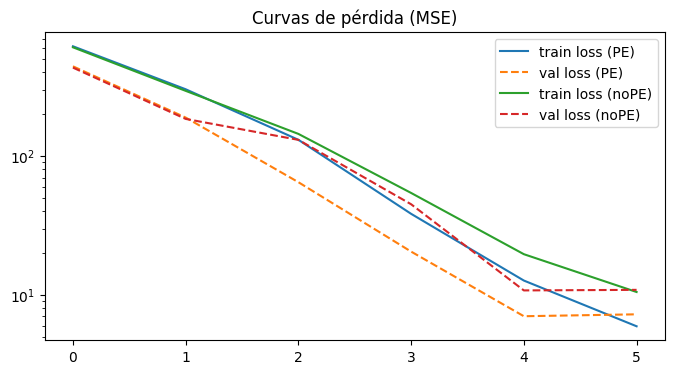

In [9]:
# opcional: usar un subconjunto para acelerar (descomentar si quiere pruebas rápidas)
# small_subset = 2000
# train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, sampler=torch.utils.data.SubsetRandomSampler(range(small_subset)))

# Entrenar modelo con PE
history_pe = train_model(model_pe, train_loader, val_loader=test_loader, epochs=EPOCHS)
# Entrenar modelo sin PE
history_nope = train_model(model_nope, train_loader, val_loader=test_loader, epochs=EPOCHS)

# Mostrar curvas de pérdida
plt.figure(figsize=(8,4))
plt.plot(history_pe['train_loss'], label='train loss (PE)')
plt.plot(history_pe['val_loss'], '--', label='val loss (PE)')
plt.plot(history_nope['train_loss'], label='train loss (noPE)')
plt.plot(history_nope['val_loss'], '--', label='val loss (noPE)')
plt.yscale('log')
plt.legend()
plt.title('Curvas de pérdida (MSE)')
plt.show()

## 9) Mini-Experimento 2 — MSE en secuencias ordenadas y barajadas
Para la partición de test: se calcula el MSE en secuencias tal como están (ordenadas),
y luego en secuencias barajadas internamente (cada ventana permutada aleatoriamente).
Se grafican ambos MSE, para cada modelo.

MSE (PE) — ordenado: 7.232896, barajado: 11.445848, Δ: 4.212951
MSE (noPE) — ordenado: 10.853769, barajado: 10.853768, Δ: -0.000000


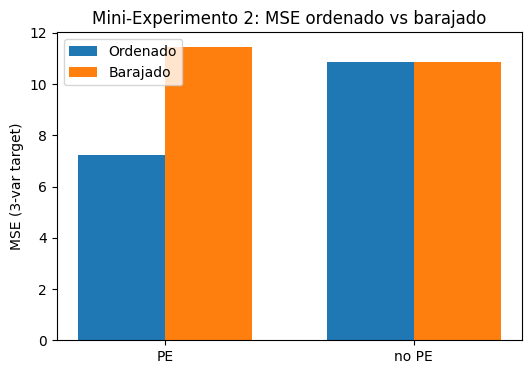

In [10]:
# función para barajar internamente cada ventana (permuta por muestra)
def shuffle_windows_internally(X_arr):
    X_shuffled = X_arr.copy()
    for i in range(X_shuffled.shape[0]):
        perm = np.random.permutation(X_shuffled.shape[1])
        X_shuffled[i] = X_shuffled[i, perm, :]
    return X_shuffled

# Evaluación ordenada
mse_pe_ordered = evaluate_mse(model_pe, X_test, Y_test)
mse_nope_ordered = evaluate_mse(model_nope, X_test, Y_test)

# Evaluación barajada (internamente por ventana)
X_test_shuffled = shuffle_windows_internally(X_test)
mse_pe_shuffled = evaluate_mse(model_pe, X_test_shuffled, Y_test)
mse_nope_shuffled = evaluate_mse(model_nope, X_test_shuffled, Y_test)

print('MSE (PE) — ordenado: {:.6f}, barajado: {:.6f}, Δ: {:.6f}'.format(mse_pe_ordered, mse_pe_shuffled, mse_pe_shuffled - mse_pe_ordered))
print('MSE (noPE) — ordenado: {:.6f}, barajado: {:.6f}, Δ: {:.6f}'.format(mse_nope_ordered, mse_nope_shuffled, mse_nope_shuffled - mse_nope_ordered))

# Gráfica de barras comparativa
labels = ['PE', 'no PE']
ordered = [mse_pe_ordered, mse_nope_ordered]
shuffled = [mse_pe_shuffled, mse_nope_shuffled]

x = np.arange(len(labels))
width = 0.35
plt.figure(figsize=(6,4))
plt.bar(x - width/2, ordered, width, label='Ordenado')
plt.bar(x + width/2, shuffled, width, label='Barajado')
plt.ylabel('MSE (3-var target)')
plt.title('Mini-Experimento 2: MSE ordenado vs barajado')
plt.xticks(x, labels)
plt.legend()
plt.show()

## 10) Interpretación rápida
- Si el Transformer **sin PE** muestra poca diferencia entre ordenado y barajado, confirma la hipótesis: no distingue el orden.
- Si el Transformer **con PE** muestra mayor aumento del MSE al barajar, entonces la PE le permite usar información de posición.

